# Analysis of MGF-GRB 180128A

<large>In this analysis, we are using catalog file /Users/salim/FermiData/gll_psc_v27.fit, to analyze without and with GRB and get TS map. Later, we will use updated catalog and see if something changes.</small>


In [1]:
# --- imports
import os, sys, shutil
from pathlib import Path
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pathlib import Path
from LATSourceModel import SourceList
from make4FGLxml import *
from xml.etree import ElementTree as ET
# Fermitools python apps
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from UpperLimits import UpperLimits

# If you also use LATSourceModel / make4FGLxml:
try:
    from LATSourceModel import SourceList
except Exception:
    SourceList = None  # optional; we'll show a pure-XML fallback too

# ---- user-config (EDIT THESE)
SRC_NAME   = "GRB180128A"
SRC_RA     = 11.888058       # deg
SRC_DEC    = -25.288800      # deg

# 500 s window around T0
T0         = 538809001.59793
TMIN       = T0
TMAX       = T0 + 500

ROI_DEG    = 12.0
EMIN_MEV   = 100.0
EMAX_MEV   = 100000.0
ZMAX       = 100.0

# Choose one consistent mode; we use TRANSIENT020E for short window
EVCLASS    = 8               # P8R3_TRANSIENT class bit
EVTYPE     = 3               # FRONT+BACK
IRFS       = "P8R3_TRANSIENT020E_V3"
ISO_BASENAME = "iso_P8R3_TRANSIENT020E_V3_v1.txt"

# Paths (EDIT: base folder with your FT1/FT2)
BASE = Path("/Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A").expanduser()
FT1  = BASE / "L250924145019039FD35899_EV00.fits"  # FT1
FT2  = BASE / "L250924145019039FD35899_SC00.fits"  # FT2

# Output dir for this single-example run
OUT  = BASE / "GRB180128A_Analysis" # Results are stored in 
OUT.mkdir(parents=True, exist_ok=True)

FT1_FILT = OUT / "filtered_evts.fits"
FT1_MKT  = OUT / "filtered_gti.fits"
LTCUBE   = OUT / "ltcube.fits"
EXPMAP   = OUT / "expmap.fits"

# Model files (no-GRB and with-GRB)
XML_NOGRB_psc22 = OUT / "model_without_grb_psc22.xml"
XML_WITH  = OUT / "model_with_grb.xml"

# TS map (no GRB in model)
TSMAP_NOGRB = OUT / "tsmap_nogrb.fits"

# Diffuse templates from FERMI_DIR
FERMI_DIR = Path(os.environ["FERMI_DIR"])
DIFF_GAL  = FERMI_DIR / "refdata/fermi/galdiffuse/gll_iem_v07.fits"
DIFF_ISO  = FERMI_DIR / f"refdata/fermi/galdiffuse/{ISO_BASENAME}"

# Sanity checks
assert FT1.exists(), f"Missing FT1: {FT1}"
assert FT2.exists(), f"Missing FT2: {FT2}"
assert DIFF_GAL.exists(), f"Missing Galactic diffuse: {DIFF_GAL}"
assert DIFF_ISO.exists(), f"Missing ISO diffuse: {DIFF_ISO}"

print("Config OK. Outputs ->", OUT)


This is make4FGLDR3xml version 01r09.
The default diffuse model files and names are for P8R3, 4FGL DRs, and the default fermitools directory locations.
Config OK. Outputs -> /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis


In [2]:
def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile


def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    # Scheme A: ANGSEP<=zmax-ROI enforced in GTIs; later we set ltcube zmax=180
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl


def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0        # since limb handled at GTI stage
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile


def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0     # good for 12° ROI at 100 MeV
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile



def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()



In [3]:
# 1) gtselect
_ = gtselect_filter_events(
    ifl=FT1, gtselect_outfile=FT1_FILT, evclass=EVCLASS, evtype=EVTYPE,
    ra=SRC_RA, dec=SRC_DEC, rad=ROI_DEG, tmin=TMIN, tmax=TMAX,
    emin=EMIN_MEV, emax=EMAX_MEV, zmin=0.0, zmax=ZMAX
)

# Quick count
with fits.open(FT1_FILT) as h:
    n_events = h['EVENTS'].header.get('NAXIS2', len(h['EVENTS'].data))
print("\n Selected events:", n_events)

# 2) gtmktime (ANGSEP scheme)
_ = gtmaketime_events(
    scfile=FT2, evfile=FT1_FILT, gtmaketime_ofl=FT1_MKT,
    ra_src=SRC_RA, dec_src=SRC_DEC, roi_deg=ROI_DEG, zmax_deg=ZMAX
)

# Count again after GTIs
with fits.open(FT1_MKT) as h:
    n_events2 = h['EVENTS'].header.get('NAXIS2', len(h['EVENTS'].data))
print("Events after GTIs:", n_events2)


[gtselect] time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_evts.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=538809001.59793 tmax=538809501.59793 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_evts.fits ra=11.888058 dec=-25.2888 rad=12.0 tmin=538809001.59793 tmax=538809501.59793 emin=100.0 emax=100000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.20
user 0.

In [4]:
# 3) gtltcube
_ = gt_ltcube(FT2, FT1_MKT, LTCUBE)

# 4) gtdiffrsp (for unbinned fits)
# We'll run it twice: once for the no-GRB model XML, once more later if we alter the model.
# For now we need a model XML; we'll build a minimal "no-GRB" model next, then call diffRsp.

print("Exposure cube done.")


[gtltcube] time -p gtltcube evfile="/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits" evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtltcube evfile="/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits" evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180

# Use older version of gll_psc_ files

In [5]:
# Cell 5 — Build a gtburst-style XML model WITHOUT the GRB (4FGL + diffuse only)
# Here we used 


from pathlib import Path
import xml.etree.ElementTree as ET

# import your make4FGLxml srcList (ensure it's on PYTHONPATH or same folder)
# from make4FGLxml import srcList
# (assuming already imported earlier in your notebook)
# from your_script import srcList

# ---- 4FGL DR-4 catalog (EDIT if needed)
#CATALOG = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit")
CATALOG = Path("/Users/salim/FermiData/gll_psc_v22.fit")  # DR-3 alternative

# ---- sanity checks (expects Cell 1 vars: DIFF_GAL, DIFF_ISO, FT1_MKT, OUT, XML_NOGRB, SRC_NAME)
assert CATALOG.exists(), f"Missing 4FGL catalog: {CATALOG}"
assert Path(DIFF_GAL).exists(), f"Missing Galactic diffuse: {DIFF_GAL}"
assert Path(DIFF_ISO).exists(), f"Missing isotropic diffuse: {DIFF_ISO}"
assert Path(FT1_MKT).exists(), f"Missing post-gtmktime FT1: {FT1_MKT}"
OUT.mkdir(parents=True, exist_ok=True)

# ---- gtburst-like knobs for short transient windows
FREE_RADIUS = 1e-6   # free params for sources within this radius (deg)
NORMS_ONLY  = True  # free only normalizations for stability
# EXTRA_RADIUS = 12.0

# ---- output file
XML_NOGRB = OUT / XML_NOGRB_psc22.name  # keep your provided name in same OUT dir

# ---- Build with your make4FGLxml srcList
# If your srcList supports DRversion=4, set 4; otherwise use 3 (works with DR-4 catalogs)
DRVERSION = 2  # or 4 if your script accepts it

xml_model = srcList(
    sources=str(CATALOG),
    ft1=str(FT1_MKT),
    out=str(XML_NOGRB),
    DRversion=DRVERSION
)

# makeModel(
#   GDfile, GDname, ISOfile, ISOname, normsOnly, extDir, radLim, maxRad, ExtraRad,
#   sigFree, varFree, psForce, E2CAT, makeRegion, GIndexFree, wd, oldNames
# )
xml_model.makeModel(
    GDfile=str(DIFF_GAL),
    GDname="gll_iem_v07",
    ISOfile=str(DIFF_ISO),
    ISOname="iso_diffuse",
    normsOnly=NORMS_ONLY,    
    radLim=FREE_RADIUS
)

print(f"[write] {XML_NOGRB}")

# ---- quick verification (no GRB present; diffuse present)
root = ET.parse(XML_NOGRB).getroot()
names = [s.attrib.get("name","") for s in root.findall(".//source")]
print("Total sources:", len(names))
print("Has Galactic diffuse:", "gll_iem_v07" in names)
print("Has ISO diffuse:", "iso_diffuse" in names)
print("Contains GRB180128A entry:", any(n == SRC_NAME for n in names))


Creating file and adding sources from 4FGL
Added 153 point sources and 0 extended sources
[write] /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc22.xml
Total sources: 155
Has Galactic diffuse: True
Has ISO diffuse: True
Contains GRB180128A entry: False


In [6]:
# Unbinned exposure map (keep IRFs consistent!)
_ = exp_map(expmap_input_ifl=FT1_MKT, scfile=FT2, ltcube_file=LTCUBE,
            expmap_outfile=EXPMAP, irf=IRFS)


# Diffuse responses for the EXACT FT1 you're fitting (post-gtmktime) with the *_nosrc.xml
diff_rsp(FT1_MKT, FT2, XML_NOGRB, IRFS)


print("gtexpmap + gtdiffrsp done")


[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT

# Perform fit

In [7]:
BG_XML_FIT = OUT / "model_without_grb_FIT_psc22.xml"

obs_bg  = UnbinnedObs(str(FT1_MKT), str(FT2), expMap=str(EXPMAP), expCube=str(LTCUBE), irfs=IRFS)
like_bg = UnbinnedAnalysis(obs_bg, srcModel=str(XML_NOGRB_psc22), optimizer="NEWMINUIT")

print("Initial -logL:", float(like_bg()))
try:
    like_bg.fit(verbosity=0, covar=True)
except Exception:
    like_bg.fit(verbosity=0, covar=False)


like_bg.fit(tol=1e-3, verbosity=0)

# Save the fitted background model to a new XML
like_bg.logLike.writeXml(str(BG_XML_FIT))
print("Wrote fitted background XML:", BG_XML_FIT)


Initial -logL: 38.91542326134811
Wrote fitted background XML: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_FIT_psc22.xml


In [8]:
# Freeze courses except diffused backgrounds for TS maps

In [9]:
import xml.etree.ElementTree as ET
from pathlib import Path

def freeze_all_except_diffuse(xml_in, xml_out):
    """
    Freeze all params in a fitted LAT XML, then re-free only the diffuse norms.
    - 'Diffuse' is detected by source name (gll_iem*/galactic/iso*/isotropic).
    - 'Norm' params covered: Prefactor, Normalization, norm, Value, ScaleFactor.
    """
    xml_in, xml_out = Path(xml_in), Path(xml_out)
    tree = ET.parse(xml_in)
    root = tree.getroot()

    def is_diffuse(name: str) -> bool:
        n = (name or "").lower()
        return ("gll_iem" in n) or ("gal" in n and "4fgl" not in n) or n.startswith("iso_") or ("isotropic" in n)

    norm_keys = {"Prefactor", "Normalization", "norm", "Value", "ScaleFactor"}

    for src in root.findall(".//source"):
        name = src.attrib.get("name", "")
        # Freeze everything
        for par in src.findall(".//parameter"):
            if "free" in par.attrib:
                par.set("free", "0")

        # Now re-free only diffuse normalizations
        if is_diffuse(name):
            spec = src.find(".//spectrum")
            if spec is None:
                continue
            for par in spec.findall(".//parameter"):
                pname = par.attrib.get("name", "")
                if pname in norm_keys:
                    par.set("free", "1")  # free only the normalization
                else:
                    par.set("free", "0")  # keep others (e.g., Index) frozen

    tree.write(xml_out, encoding="utf-8", xml_declaration=True)
    print(f"✓ wrote frozen (diffuse-norm-free) model: {xml_out}")

# --- usage ---
fitted_xml = OUT / "model_without_grb_FIT_psc22.xml"     # your fitted model
frozen_xml = OUT / "GRB180128A_frozen_for_tsmap.xml"
freeze_all_except_diffuse(fitted_xml, frozen_xml)


✓ wrote frozen (diffuse-norm-free) model: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_frozen_for_tsmap.xml


# Create TS map

In [10]:
# In[12]: TS map with NO-GRB model, background fixed to fitted values (BG_XML_FIT)

# Grid / projection settings
NX, NY   = 80, 80
BINSZ    = 0.2
RA_CEN   = SRC_RA
DEC_CEN  = SRC_DEC

# Output
TSMAP_NOGRB = OUT / "tsmap_nogrb_psc22.fits"

# Configure gttsmap via gt_apps
my_apps.TsMap['evfile']    = str(FT1_MKT)
my_apps.TsMap['scfile']    = str(FT2)
my_apps.TsMap['expcube']   = str(LTCUBE)
my_apps.TsMap['expmap']    = str(EXPMAP)
my_apps.TsMap['srcmdl']    = str(frozen_xml)     # <-- fitted background, NO GRB
my_apps.TsMap['irfs']      = IRFS
my_apps.TsMap['nxpix']     = NX
my_apps.TsMap['nypix']     = NY
my_apps.TsMap['binsz']     = BINSZ
my_apps.TsMap['xref']      = RA_CEN
my_apps.TsMap['yref']      = DEC_CEN
my_apps.TsMap['proj']      = 'AIT'
my_apps.TsMap['coordsys']  = 'CEL'
my_apps.TsMap['statistic'] = 'UNBINNED'
my_apps.TsMap['optimizer'] = 'NEWMINUIT'
my_apps.TsMap['outfile']   = str(TSMAP_NOGRB)
my_apps.TsMap['chatter']   = 2
my_apps.TsMap['clobber']   = 'yes'

print("[gttsmap no-src]", my_apps.TsMap.command())
my_apps.TsMap.run()

print("✓ TS map (no-source) written:", TSMAP_NOGRB)


[gttsmap no-src] time -p gttsmap irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits srcmdl=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_frozen_for_tsmap.xml statistic="UNBINNED" optimizer="NEWMINUIT" ftol=0.001 toltype="ABS" evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expmap=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/expmap.fits cmap=none bexpmap=none wmap=none psfcorr=yes edisp_bins=0 outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/tsmap_nogrb_psc22.fits nxpix=80 nypix=80 binsz=0.2 coordsys="CEL" xref=11.888058 yref=-25.2888 proj="AIT" ch

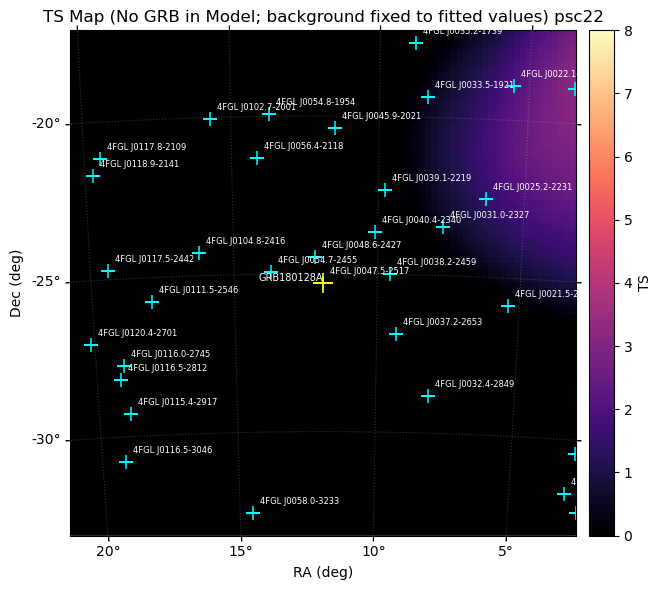

In [11]:
# In[13]: Plot √TS for the no-GRB TS map (labels from fitted background XML)

import warnings, os
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings("ignore", category=AstropyWarning)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import xml.etree.ElementTree as ET

# ---- inputs from previous cells
NOSRC_FITS = str(TSMAP_NOGRB)        # OUT / "tsmap_nogrb.fits"
XML_MODEL  = str(BG_XML_FIT)         # OUT / "model_without_grb_FIT.xml" (fitted, no GRB)
GRB_NAME   = SRC_NAME                # "GRB200415A"

def world_to_pix(wcs2d, ra, dec):
    x, y = wcs2d.world_to_pixel_values(ra, dec)
    return float(np.asarray(x).ravel()[0]), float(np.asarray(y).ravel()[0])

def inside(arr2d, x, y):
    ny, nx = arr2d.shape
    return (0 <= x < nx) and (0 <= y < ny)

def get_sources(xml_path):
    out = []
    if not os.path.exists(xml_path):
        return out
    root = ET.parse(xml_path).getroot()
    for src in root.findall(".//source"):
        name = src.attrib.get("name","")
        sp = src.find(".//spatialModel")
        if sp is None:
            continue
        pra  = sp.find('.//parameter[@name="RA"]')
        pdec = sp.find('.//parameter[@name="DEC"]')
        if pra is None or pdec is None:
            continue
        try:
            ra  = float(pra.attrib["value"])
            dec = float(pdec.attrib["value"])
        except Exception:
            continue
        out.append((name, ra, dec))
    return out

def setup_axes_deg(ax):
    try:
        lon, lat = ax.coords[0], ax.coords[1]
        lon.set_format_unit(u.deg); lat.set_format_unit(u.deg)
        ax.coords.grid(color="w", alpha=0.2, ls=":")
        ax.set_xlabel("RA (deg)"); ax.set_ylabel("Dec (deg)")
    except Exception:
        ax.set_xlabel("RA (deg)"); ax.set_ylabel("Dec (deg)")

# ---- load only the no-source TS map
hdu = fits.open(NOSRC_FITS)[0]
ts = np.array(hdu.data, float)
wcs = WCS(hdu.header)
ts[~np.isfinite(ts)] = 0.0

# visualize sqrt(TS)
img = np.sqrt(np.clip(ts, 0, None))
vmin, vmax = 0.0, 8.0

# label sources from fitted background model
sources = get_sources(XML_MODEL)

# ---- plot one panel
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax, cmap="magma")

ny, nx = img.shape
ax.set_xlim(-0.5, nx - 0.5)
ax.set_ylim(-0.5, ny - 0.5)
ax.set_facecolor("black")
ax.set_aspect("auto")
ax.set_title("TS Map (No GRB in Model; background fixed to fitted values) psc22")
setup_axes_deg(ax)

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\mathrm{TS}}$")

# overlay catalog sources (cyan '+')
for name, ra, dec in sources:
    x, y = world_to_pix(wcs, ra, dec)
    if inside(img, x, y):
        ax.plot(x, y, marker="+", color="cyan", ms=10, mew=1.1, linestyle="None")
        ax.text(x + 1.1, y + 1.1, name, color="white", fontsize=6, va="bottom", ha="left")

# also mark the GRB position (yellow '+') for reference
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)
if inside(img, xg, yg):
    ax.plot(xg, yg, marker="+", color="yellow", ms=14, mew=1.2, linestyle="None")
    ax.text(xg, yg, GRB_NAME, color="white", fontsize=7, va="bottom", ha="right")

plt.tight_layout()
plt.show()


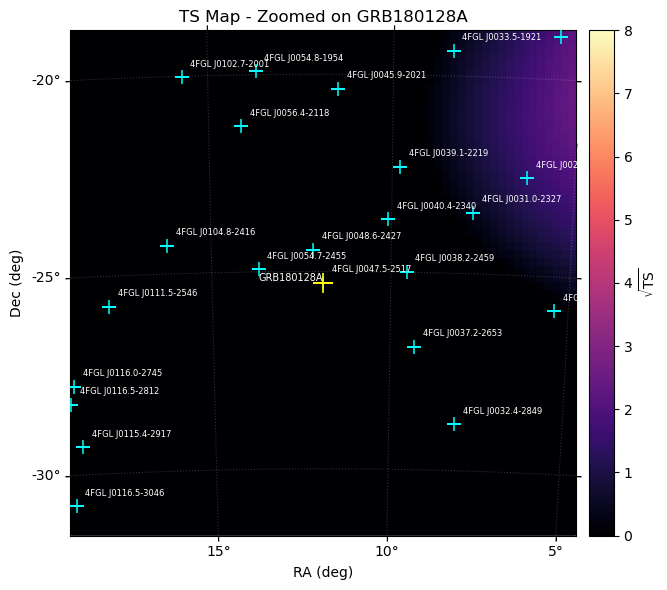

In [12]:
# ---- plot one panel with zoom
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax, cmap="magma")

ny, nx = img.shape

# Calculate GRB position in pixels
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)

# Set zoom limits around GRB position (adjust zoom factor as needed)
zoom_factor = 0.8  # Smaller = more zoomed in
x_center, y_center = xg, yg
x_width = nx * zoom_factor
y_width = ny * zoom_factor

x_min = x_center - x_width/2
x_max = x_center + x_width/2
y_min = y_center - y_width/2
y_max = y_center + y_width/2

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_facecolor("black")
ax.set_aspect("auto")
ax.set_title(f"TS Map - Zoomed on {GRB_NAME}")
setup_axes_deg(ax)

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\sqrt{\mathrm{TS}}$")

# overlay catalog sources (cyan '+') - ONLY if they are within zoom region
for name, ra, dec in sources:
    x, y = world_to_pix(wcs, ra, dec)
    # Check if source is within the zoomed region
    if (x_min <= x <= x_max) and (y_min <= y <= y_max) and inside(img, x, y):
        ax.plot(x, y, marker="+", color="cyan", ms=10, mew=1.1, linestyle="None")
        ax.text(x + 1.1, y + 1.1, name, color="white", fontsize=6, va="bottom", ha="left")

# also mark the GRB position (yellow '+') for reference
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)
if inside(img, xg, yg):
    ax.plot(xg, yg, marker="+", color="yellow", ms=14, mew=1.2, linestyle="None")
    ax.text(xg, yg, GRB_NAME, color="white", fontsize=7, va="bottom", ha="right")

plt.tight_layout()
plt.show()


# Consider other catalog file and see the effect

In [13]:
XML_NOGRB_psc35 = OUT / "model_without_grb_psc35.xml"

# Cell 5 — Build a gtburst-style XML model WITHOUT the GRB (4FGL + diffuse only)
# ---- 4FGL DR-4 catalog (EDIT if needed)
CATALOG = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit")
#CATALOG = Path("/Users/salim/FermiData/gll_psc_v27.fit")

# ---- sanity checks (expects Cell 1 vars: DIFF_GAL, DIFF_ISO, FT1_MKT, OUT, XML_NOGRB)
assert CATALOG.exists(), f"Missing 4FGL DR-4 catalog: {CATALOG}"
assert Path(DIFF_GAL).exists(), f"Missing Galactic diffuse: {DIFF_GAL}"
assert Path(DIFF_ISO).exists(), f"Missing isotropic diffuse: {DIFF_ISO}"
assert Path(FT1_MKT).exists(), f"Missing post-gtmktime FT1: {FT1_MKT}"
OUT.mkdir(parents=True, exist_ok=True)

# ---- gtburst-like knobs for short transient windows
FREE_RADIUS   = 1e-6   # free params for sources within this radius
#MAX_FREE_RAD  = 8.0   # allow a few bright/variable just outside to be free
#EXTRA_RADIUS  = 12.0  # include fixed sources out to ROI+EXTRA_RADIUS
NORMS_ONLY    = True  # free only normalizations for stability

# ---- Build SourceList with the *new* API:
# SourceList(catalog_file, ROI, output_name=None, DR=4, write_directory=None)
# ROI can be the FT1 filename or [RA, DEC, radius].
sl = SourceList(
    catalog_file=str(CATALOG),
    ROI=str(FT1_MKT),                             # infer ROI from your event file
    output_name=XML_NOGRB_psc35.name,                   # file name only
    DR=4,                                         # 4FGL DR-4
    write_directory=str(OUT)                      # directory to write into
)




# ---- Make the model with the *new* argument names (underscores, not camelCase)
# make_model(galactic_file, galactic_name, isotropic_file, isotropic_name,
#            norms_free_only, extended_directory, free_radius, max_free_radius,
#            extra_radius, sigma_to_free, variable_free, force_point_sources,
#            extended_catalog_names, make_region, region_file, galactic_index_free,
#            use_old_names)
sl.make_model(
    galactic_file=str(DIFF_GAL),
    galactic_name="gll_iem_v07",
    isotropic_file=str(DIFF_ISO),
    isotropic_name="iso_diffuse",
    norms_free_only=NORMS_ONLY,
    free_radius=FREE_RADIUS,
    #max_free_radius=MAX_FREE_RAD,
    #extra_radius=EXTRA_RADIUS,
    make_region=True
)

print(f"[write] {XML_NOGRB_psc35}")

# ---- quick verification (no GRB present; diffuse present)
root = ET.parse(XML_NOGRB_psc35).getroot()
names = [s.attrib.get("name","") for s in root.findall(".//source")]
print("Total sources:", len(names))
print("Has Galactic diffuse:", "gll_iem_v07" in names)
print("Has ISO diffuse:", "iso_diffuse" in names)
print("Contains GRB180128A entry:", any(n == SRC_NAME for n in names))


Creating spatial and spectral model from the 4FGL DR-4 catalog: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit.
Added 219 point sources and 0 extended sources.
Building ds9-style region file...done!
File saved as /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ROI_model_without_grb_psc35.reg.
[write] /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc35.xml
Total sources: 221
Has Galactic diffuse: True
Has ISO diffuse: True
Contains GRB180128A entry: False


In [14]:
# Unbinned exposure map (keep IRFs consistent!)
_ = exp_map(expmap_input_ifl=FT1_MKT, scfile=FT2, ltcube_file=LTCUBE,
            expmap_outfile=EXPMAP, irf=IRFS)


# Diffuse responses for the EXACT FT1 you're fitting (post-gtmktime) with the *_nosrc.xml
diff_rsp(FT1_MKT, FT2, XML_NOGRB, IRFS)


print("gtexpmap + gtdiffrsp done")


[gtexpmap] time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/expmap.fits irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" srcrad=24.0 nlong=48 nlat=48 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtexpmap evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT

In [15]:
BG_XML_FIT = OUT / "model_without_grb_psc35.xml"

obs_bg  = UnbinnedObs(str(FT1_MKT), str(FT2), expMap=str(EXPMAP), expCube=str(LTCUBE), irfs=IRFS)
like_bg = UnbinnedAnalysis(obs_bg, srcModel=str(XML_NOGRB_psc22), optimizer="NEWMINUIT")

print("Initial -logL:", float(like_bg()))
try:
    like_bg.fit(verbosity=0, covar=True)
except Exception:
    like_bg.fit(verbosity=0, covar=False)


like_bg.fit(tol=1e-3, verbosity=0)

# Save the fitted background model to a new XML
like_bg.logLike.writeXml(str(BG_XML_FIT))
print("Wrote fitted background XML:", BG_XML_FIT)


Initial -logL: 38.91542326134811
Wrote fitted background XML: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc35.xml


In [16]:
# --- usage ---
fitted_xml = OUT / "model_without_grb_psc35.xml"     # your fitted model
frozen_xml = OUT / "GRB180128A_psc35_frozen_for_tsmap.xml"
freeze_all_except_diffuse(fitted_xml, frozen_xml)

✓ wrote frozen (diffuse-norm-free) model: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_psc35_frozen_for_tsmap.xml


In [17]:
# In[12]: TS map with NO-GRB model, background fixed to fitted values (BG_XML_FIT)

# Grid / projection settings
NX, NY   = 80, 80
BINSZ    = 0.2
RA_CEN   = SRC_RA
DEC_CEN  = SRC_DEC

# Output
TSMAP_NOGRB = OUT / "tsmap_nogrb_psc35.fits"

# Configure gttsmap via gt_apps
my_apps.TsMap['evfile']    = str(FT1_MKT)
my_apps.TsMap['scfile']    = str(FT2)
my_apps.TsMap['expcube']   = str(LTCUBE)
my_apps.TsMap['expmap']    = str(EXPMAP)
my_apps.TsMap['srcmdl']    = str(frozen_xml)     # <-- fitted background, NO GRB
my_apps.TsMap['irfs']      = IRFS
my_apps.TsMap['nxpix']     = NX
my_apps.TsMap['nypix']     = NY
my_apps.TsMap['binsz']     = BINSZ
my_apps.TsMap['xref']      = RA_CEN
my_apps.TsMap['yref']      = DEC_CEN
my_apps.TsMap['proj']      = 'AIT'
my_apps.TsMap['coordsys']  = 'CEL'
my_apps.TsMap['statistic'] = 'UNBINNED'
my_apps.TsMap['optimizer'] = 'NEWMINUIT'
my_apps.TsMap['outfile']   = str(TSMAP_NOGRB)
my_apps.TsMap['chatter']   = 2
my_apps.TsMap['clobber']   = 'yes'

print("[gttsmap no-src]", my_apps.TsMap.command())
my_apps.TsMap.run()

print("✓ TS map (no-source) written:", TSMAP_NOGRB)


[gttsmap no-src] time -p gttsmap irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits srcmdl=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_psc35_frozen_for_tsmap.xml statistic="UNBINNED" optimizer="NEWMINUIT" ftol=0.001 toltype="ABS" evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expmap=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/expmap.fits cmap=none bexpmap=none wmap=none psfcorr=yes edisp_bins=0 outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/tsmap_nogrb_psc35.fits nxpix=80 nypix=80 binsz=0.2 coordsys="CEL" xref=11.888058 yref=-25.2888 proj="A

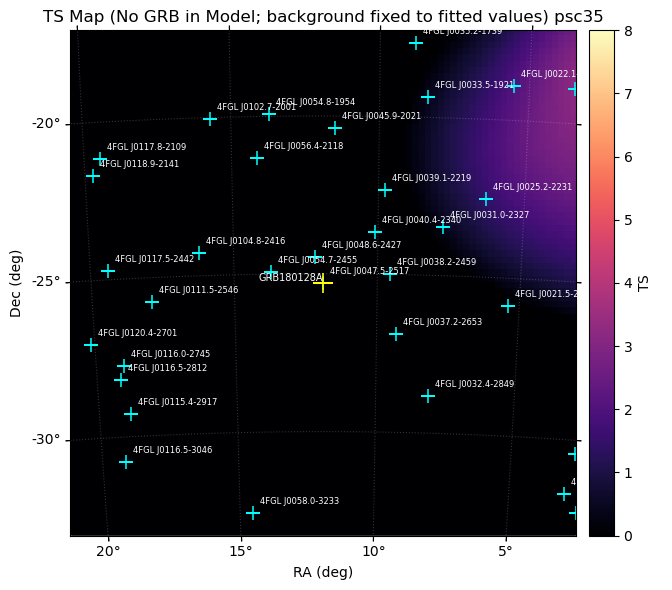

In [18]:
# In[13]: Plot √TS for the no-GRB TS map (labels from fitted background XML)

import warnings, os
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings("ignore", category=AstropyWarning)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import xml.etree.ElementTree as ET

# ---- inputs from previous cells
NOSRC_FITS = str(TSMAP_NOGRB)        # OUT / "tsmap_nogrb.fits"
XML_MODEL  = str(BG_XML_FIT)         # OUT / "model_without_grb_FIT.xml" (fitted, no GRB)
GRB_NAME   = SRC_NAME                # "GRB200415A"

def world_to_pix(wcs2d, ra, dec):
    x, y = wcs2d.world_to_pixel_values(ra, dec)
    return float(np.asarray(x).ravel()[0]), float(np.asarray(y).ravel()[0])

def inside(arr2d, x, y):
    ny, nx = arr2d.shape
    return (0 <= x < nx) and (0 <= y < ny)

def get_sources(xml_path):
    out = []
    if not os.path.exists(xml_path):
        return out
    root = ET.parse(xml_path).getroot()
    for src in root.findall(".//source"):
        name = src.attrib.get("name","")
        sp = src.find(".//spatialModel")
        if sp is None:
            continue
        pra  = sp.find('.//parameter[@name="RA"]')
        pdec = sp.find('.//parameter[@name="DEC"]')
        if pra is None or pdec is None:
            continue
        try:
            ra  = float(pra.attrib["value"])
            dec = float(pdec.attrib["value"])
        except Exception:
            continue
        out.append((name, ra, dec))
    return out

def setup_axes_deg(ax):
    try:
        lon, lat = ax.coords[0], ax.coords[1]
        lon.set_format_unit(u.deg); lat.set_format_unit(u.deg)
        ax.coords.grid(color="w", alpha=0.2, ls=":")
        ax.set_xlabel("RA (deg)"); ax.set_ylabel("Dec (deg)")
    except Exception:
        ax.set_xlabel("RA (deg)"); ax.set_ylabel("Dec (deg)")

# ---- load only the no-source TS map
hdu = fits.open(NOSRC_FITS)[0]
ts = np.array(hdu.data, float)
wcs = WCS(hdu.header)
ts[~np.isfinite(ts)] = 0.0

# visualize sqrt(TS)
img = np.sqrt(np.clip(ts, 0, None))
vmin, vmax = 0.0, 8.0

# label sources from fitted background model
sources = get_sources(XML_MODEL)

# ---- plot one panel
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax, cmap="magma")

ny, nx = img.shape
ax.set_xlim(-0.5, nx - 0.5)
ax.set_ylim(-0.5, ny - 0.5)
ax.set_facecolor("black")
ax.set_aspect("auto")
ax.set_title("TS Map (No GRB in Model; background fixed to fitted values) psc35")
setup_axes_deg(ax)

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\mathrm{TS}}$")

# overlay catalog sources (cyan '+')
for name, ra, dec in sources:
    x, y = world_to_pix(wcs, ra, dec)
    if inside(img, x, y):
        ax.plot(x, y, marker="+", color="cyan", ms=10, mew=1.1, linestyle="None")
        ax.text(x + 1.1, y + 1.1, name, color="white", fontsize=6, va="bottom", ha="left")

# also mark the GRB position (yellow '+') for reference
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)
if inside(img, xg, yg):
    ax.plot(xg, yg, marker="+", color="yellow", ms=14, mew=1.2, linestyle="None")
    ax.text(xg, yg, GRB_NAME, color="white", fontsize=7, va="bottom", ha="right")

plt.tight_layout()
plt.show()


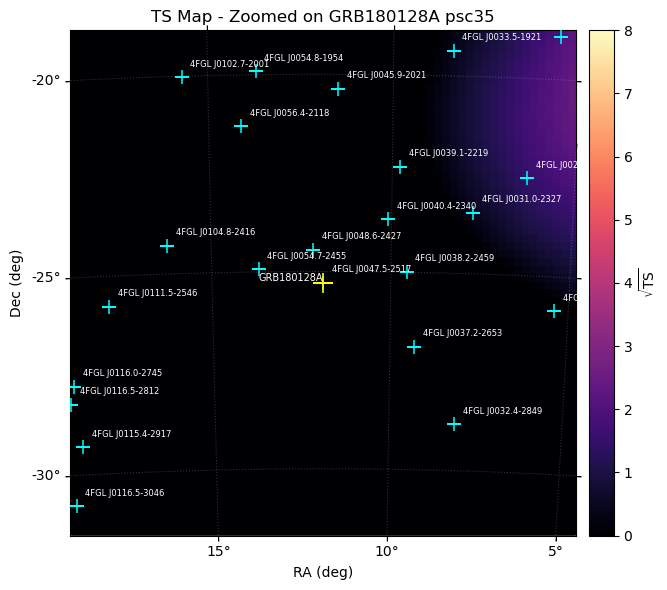

In [19]:
# ---- plot one panel with zoom
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax, cmap="magma")

ny, nx = img.shape

# Calculate GRB position in pixels
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)

# Set zoom limits around GRB position (adjust zoom factor as needed)
zoom_factor = 0.8  # Smaller = more zoomed in
x_center, y_center = xg, yg
x_width = nx * zoom_factor
y_width = ny * zoom_factor

x_min = x_center - x_width/2
x_max = x_center + x_width/2
y_min = y_center - y_width/2
y_max = y_center + y_width/2

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_facecolor("black")
ax.set_aspect("auto")
ax.set_title(f"TS Map - Zoomed on {GRB_NAME} psc35")
setup_axes_deg(ax)

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(r"$\sqrt{\mathrm{TS}}$")

# overlay catalog sources (cyan '+') - ONLY if they are within zoom region
for name, ra, dec in sources:
    x, y = world_to_pix(wcs, ra, dec)
    # Check if source is within the zoomed region
    if (x_min <= x <= x_max) and (y_min <= y <= y_max) and inside(img, x, y):
        ax.plot(x, y, marker="+", color="cyan", ms=10, mew=1.1, linestyle="None")
        ax.text(x + 1.1, y + 1.1, name, color="white", fontsize=6, va="bottom", ha="left")

# also mark the GRB position (yellow '+') for reference
xg, yg = world_to_pix(wcs, SRC_RA, SRC_DEC)
if inside(img, xg, yg):
    ax.plot(xg, yg, marker="+", color="yellow", ms=14, mew=1.2, linestyle="None")
    ax.text(xg, yg, GRB_NAME, color="white", fontsize=7, va="bottom", ha="right")

plt.tight_layout()
plt.show()


# Include source for modeling 

While making TSmap freeze all background parameters 

In [20]:
XML_NOGRB_psc35 = OUT / "model_without_grb_psc35.xml"

# Cell 5 — Build a gtburst-style XML model WITHOUT the GRB (4FGL + diffuse only)
# ---- 4FGL DR-4 catalog (EDIT if needed)
CATALOG = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit")
#CATALOG = Path("/Users/salim/FermiData/gll_psc_v27.fit")

# ---- sanity checks (expects Cell 1 vars: DIFF_GAL, DIFF_ISO, FT1_MKT, OUT, XML_NOGRB)
assert CATALOG.exists(), f"Missing 4FGL DR-4 catalog: {CATALOG}"
assert Path(DIFF_GAL).exists(), f"Missing Galactic diffuse: {DIFF_GAL}"
assert Path(DIFF_ISO).exists(), f"Missing isotropic diffuse: {DIFF_ISO}"
assert Path(FT1_MKT).exists(), f"Missing post-gtmktime FT1: {FT1_MKT}"
OUT.mkdir(parents=True, exist_ok=True)

# ---- gtburst-like knobs for short transient windows
FREE_RADIUS   = 1e-6   # free params for sources within this radius
#MAX_FREE_RAD  = 8.0   # allow a few bright/variable just outside to be free
#EXTRA_RADIUS  = 12.0  # include fixed sources out to ROI+EXTRA_RADIUS
NORMS_ONLY    = True  # free only normalizations for stability

# ---- Build SourceList with the *new* API:
# SourceList(catalog_file, ROI, output_name=None, DR=4, write_directory=None)
# ROI can be the FT1 filename or [RA, DEC, radius].
sl = SourceList(
    catalog_file=str(CATALOG),
    ROI=str(FT1_MKT),                             # infer ROI from your event file
    output_name=XML_NOGRB_psc35.name,                   # file name only
    DR=4,                                         # 4FGL DR-4
    write_directory=str(OUT)                      # directory to write into
)




# ---- Make the model with the *new* argument names (underscores, not camelCase)
# make_model(galactic_file, galactic_name, isotropic_file, isotropic_name,
#            norms_free_only, extended_directory, free_radius, max_free_radius,
#            extra_radius, sigma_to_free, variable_free, force_point_sources,
#            extended_catalog_names, make_region, region_file, galactic_index_free,
#            use_old_names)
sl.make_model(
    galactic_file=str(DIFF_GAL),
    galactic_name="gll_iem_v07",
    isotropic_file=str(DIFF_ISO),
    isotropic_name="iso_diffuse",
    norms_free_only=NORMS_ONLY,
    free_radius=FREE_RADIUS,
    #max_free_radius=MAX_FREE_RAD,
    #extra_radius=EXTRA_RADIUS,
    make_region=True
)

print(f"[write] {XML_NOGRB_psc35}")

# ---- quick verification (no GRB present; diffuse present)
root = ET.parse(XML_NOGRB_psc35).getroot()
names = [s.attrib.get("name","") for s in root.findall(".//source")]
print("Total sources:", len(names))
print("Has Galactic diffuse:", "gll_iem_v07" in names)
print("Has ISO diffuse:", "iso_diffuse" in names)
print("Contains GRB180128A entry:", any(n == SRC_NAME for n in names))


Creating spatial and spectral model from the 4FGL DR-4 catalog: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/gll_psc_v35.fit.
Added 219 point sources and 0 extended sources.
Building ds9-style region file...done!
File saved as /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ROI_model_without_grb_psc35.reg.
[write] /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc35.xml
Total sources: 221
Has Galactic diffuse: True
Has ISO diffuse: True
Contains GRB180128A entry: False


/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:154: UserWarning: Region XML model /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc35.xml already exists, will be overwritten if you call the make_model method.
  warnings.warn(f'Region XML model {str(self.output_name)} already exists, will be\


In [21]:
# In[14]: Add the GRB as a PowerLaw2 point source and write a new XML (gtburst style)

from LATSourceModel import SourceList
from pathlib import Path
import xml.etree.ElementTree as ET

# Inputs from earlier cells
assert CATALOG.exists(), f"Missing catalog: {CATALOG}"
assert Path(XML_NOGRB_psc35).exists(), f"Missing background XML: {XML_NOGRB_psc35}"

# New XML filename
XML_WITH = OUT / "GRB180128A_withGRB.xml"

# Analysis band / spectral setup (PowerLaw2 defined over [emin, emax])
ANALYSIS = {
    "emin": float(EMIN_MEV),   # MeV
    "emax": float(EMAX_MEV),   # MeV
    "spectral_index": 2.0,     # start value; you can free/refit later
}

spectrum_info = {
    "model": "PowerLaw2",
    "Integral": 1e-6,                   # ph/cm^2/s over [LowerLimit, UpperLimit]
    "Integral_free": True,
    "Index": ANALYSIS["spectral_index"],
    "Index_free": True,
    "LowerLimit": ANALYSIS["emin"],
    "LowerLimit_free": False,
    "UpperLimit": ANALYSIS["emax"],
    "UpperLimit_free": False,
}

# Point Source adder: use the same ROI convention as when you built the background model
sl = SourceList(
    catalog_file=str(CATALOG),
    ROI=str(FT1_MKT),                    # infer ROI from your post-gtmktime FT1
    output_name=Path(XML_NOGRB_psc35).name,    # base model filename (the existing no-GRB XML)
    DR=4,
    write_directory=str(OUT)
)

# Append the GRB point source and write a NEW model XML
sl.add_point_source(
    source_name=SRC_NAME,
    RA=float(SRC_RA),
    DEC=float(SRC_DEC),
    spectrum_model=spectrum_info,        # PowerLaw2 with the fields above
    new_model_name=XML_WITH.name,        # write alongside XML_NOGRB in OUT
    overwrite=True
)

print("✓ wrote model with GRB:", XML_WITH)

# quick sanity check
root = ET.parse(XML_WITH).getroot()
names = [s.attrib.get("name","") for s in root.findall(".//source")]
print("Contains GRB entry:", any(n == SRC_NAME for n in names))


GRB180128A added to model, saved as /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_withGRB.xml
SourceList object attribute "output_name" now points to new file
✓ wrote model with GRB: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_withGRB.xml
Contains GRB entry: True


/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:154: UserWarning: Region XML model /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_without_grb_psc35.xml already exists, will be overwritten if you call the make_model method.
  warnings.warn(f'Region XML model {str(self.output_name)} already exists, will be\
/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:861: UserWarning: Assuming same save directory as main model.
  warnings.warn('Assuming same save directory as main model.')
/Users/salim/anaconda3/envs/fermi_env/lib/python3.9/site-packages/LATSourceModel/SourceList.py:948: UserWarning: Requested to update ds9-style .reg file but old_reg_file not specified and could not determine file name from SourceList object.
Will not update the region file.
  warnings.warn('Requested to update ds9-style .reg file but old_reg_file\


In [22]:
# In[15]: gtdiffrsp for the WITH-GRB model (no need to redo expmap/ltcube)

assert XML_WITH.exists(), f"Missing XML_WITH: {XML_WITH}"
diff_rsp(FT1_MKT, FT2, XML_WITH, IRFS)
print("✓ gtdiffrsp done for model WITH GRB:", XML_WITH)


[gtdiffrsp] time -p gtdiffrsp evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" srcmdl=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_withGRB.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=no debug=no gui=no mode="ql"
time -p gtdiffrsp evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" srcmdl=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_withGRB.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=

In [23]:
XML_WITH_FIT = OUT / "model_with_grb_FIT.xml"
obs_grb  = UnbinnedObs(str(FT1_MKT), str(FT2), expMap=str(EXPMAP), expCube=str(LTCUBE), irfs=IRFS)
like_grb = UnbinnedAnalysis(obs_grb, srcModel=str(XML_WITH), optimizer="NEWMINUIT")
print("Initial -logL (with GRB):", float(like_grb()))
try:
    like_grb.fit(verbosity=0, covar=True)
except Exception:
    like_grb.fit(verbosity=0, covar=False)
like_grb.fit(tol=1e-3, verbosity=0)

print("Final -logL (with GRB):", float(like_grb()))
TS_val = like_grb.Ts(SRC_NAME)
print(f"TS({SRC_NAME}) = {TS_val:.2f}")
like_grb.logLike.writeXml(str(XML_WITH_FIT))
print("Wrote fitted with-GRB XML:", XML_WITH_FIT)


Initial -logL (with GRB): 40.636009918653265
Final -logL (with GRB): 37.65684843580527
TS(GRB180128A) = -0.00
Wrote fitted with-GRB XML: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/model_with_grb_FIT.xml


In [24]:
# --- usage ---
fitted_xml = OUT / "model_with_grb_FIT.xml"
frozen_xml = OUT / "GRB180128A_frozen_for_tsmap.xml"
freeze_all_except_diffuse(fitted_xml, frozen_xml)


✓ wrote frozen (diffuse-norm-free) model: /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_frozen_for_tsmap.xml


In [25]:
XML_WITH_FIT_tsmap = OUT / "model_with_grb_FIT_forTSmap.xml"

In [26]:
# TS map with GRB included in the background (fixed to fitted values)

TSMAP_RESID = OUT / "tsmap_with_grb.fits"
NX, NY, BINSZ = 80, 80, 0.2

my_apps.TsMap['evfile']    = str(FT1_MKT)
my_apps.TsMap['scfile']    = str(FT2)
my_apps.TsMap['expcube']   = str(LTCUBE)
my_apps.TsMap['expmap']    = str(EXPMAP)       # unbinned exposure map (reuse is correct)
my_apps.TsMap['srcmdl']    = str(frozen_xml) # fitted model that includes the GRB
my_apps.TsMap['irfs']      = IRFS
my_apps.TsMap['nxpix']     = NX
my_apps.TsMap['nypix']     = NY
my_apps.TsMap['binsz']     = BINSZ
my_apps.TsMap['xref']      = SRC_RA
my_apps.TsMap['yref']      = SRC_DEC
my_apps.TsMap['proj']      = 'AIT'
my_apps.TsMap['coordsys']  = 'CEL'
my_apps.TsMap['statistic'] = 'UNBINNED'
my_apps.TsMap['optimizer'] = 'NEWMINUIT'
my_apps.TsMap['outfile']   = str(TSMAP_RESID)
my_apps.TsMap['clobber']   = 'yes'
print("[gttsmap residual]", my_apps.TsMap.command())
my_apps.TsMap.run()
print("Wrote residual TS map:", TSMAP_RESID)


[gttsmap residual] time -p gttsmap irfs="P8R3_TRANSIENT020E_V3" evtype="INDEF" expcube=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/ltcube.fits srcmdl=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_frozen_for_tsmap.xml statistic="UNBINNED" optimizer="NEWMINUIT" ftol=0.001 toltype="ABS" evfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/filtered_gti.fits evtable="EVENTS" scfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/L250924145019039FD35899_SC00.fits sctable="SC_DATA" expmap=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/expmap.fits cmap=none bexpmap=none wmap=none psfcorr=yes edisp_bins=0 outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/tsmap_with_grb.fits nxpix=80 nypix=80 binsz=0.2 coordsys="CEL" xref=11.888058 yref=-25.2888 proj="AIT" cha

Source                         Sep(°) TS(no-GRB)  TS(w/GRB)
────────────────────────────────────────────────────────────
4FGL J0037.2-2653                2.81        0.0        0.0
4FGL J0038.2-2459                2.13        0.0        0.0
4FGL J0040.2-2725                2.69        0.0        0.0
4FGL J0040.4-2340                2.29        0.0        0.0
4FGL J0047.5-2517                0.01        0.0        0.0
4FGL J0048.6-2427                0.87        0.0        0.0
4FGL J0054.7-2455                1.67        0.0        0.0
GRB180128A                       0.00        0.0        0.0 [GRB]

Smoothing: σ = 0.1 pix (0.02°)
Max TS (no-GRB):   10.17  (smoothed: 10.17)
Max TS (with-GRB): 8.72  (smoothed: 8.72)
Saved: /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_tsmaps.png
Saved: /Users/salim/Desktop/Projects/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_180128A/GRB180128A_Analysis/GRB180128A_tsmaps.pdf


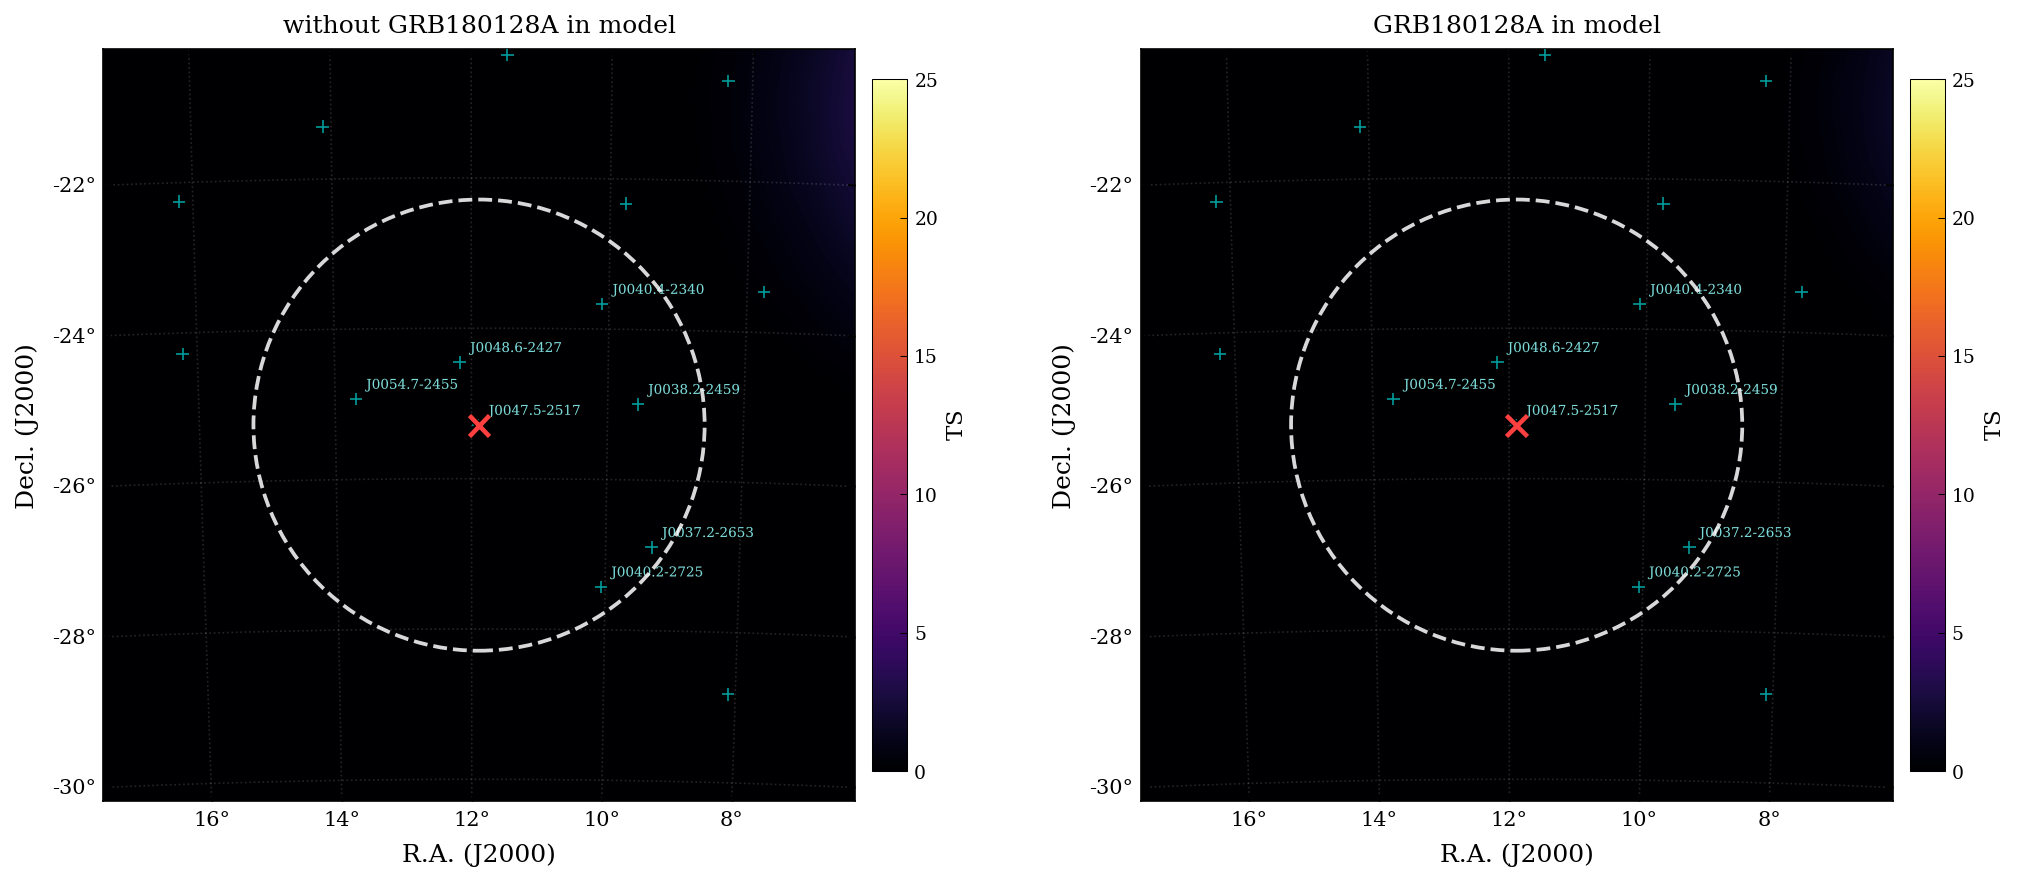

In [3]:
import warnings, os
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings("ignore", category=AstropyWarning)

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u
import xml.etree.ElementTree as ET
from matplotlib.patches import Circle
from matplotlib import patheffects
from scipy.ndimage import gaussian_filter

# ══════════════════════════════════════════════════════════════════════
#  Journal-quality matplotlib defaults (ApJ style)
# ══════════════════════════════════════════════════════════════════════
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif', 'Times New Roman', 'Times'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'mathtext.fontset': 'dejavuserif',
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
})

# ══════════════════════════════════════════════════════════════════════
#  Input files  (uses OUT, SRC_NAME, SRC_RA, SRC_DEC from Cell 2)
# ══════════════════════════════════════════════════════════════════════
RESID_FITS = OUT / "tsmap_nogrb_psc35.fits"   # TS map WITHOUT GRB in model
NOSRC_FITS = OUT / "tsmap_with_grb.fits"      # TS map WITH GRB in model (residual)
XML_MODEL  = OUT / "model_with_grb_FIT.xml"   # XML with 4FGL sources + GRB
GRB_NAME   = SRC_NAME

# ── Zoom & labeling parameters ──
ZOOM_HALF  = 5.0     # degrees from center → total 10° FOV
CIRCLE_RAD = 3.0     # radius of the dashed circle (degrees)
SMOOTH_SIG = 0.1     # Gaussian sigma in pixels (0.2°/pix)
TS_HIGHLIGHT = 4.0   # highlight sources with TS > this value

# ══════════════════════════════════════════════════════════════════════
#  Helper functions
# ══════════════════════════════════════════════════════════════════════
def world_to_pix(wcs2d, ra, dec):
    x, y = wcs2d.world_to_pixel_values(ra, dec)
    return float(np.asarray(x).ravel()[0]), float(np.asarray(y).ravel()[0])

def ang_sep(ra1, dec1, ra2, dec2):
    """Great-circle separation in degrees."""
    d = np.radians
    val = (np.sin(d(dec1))*np.sin(d(dec2)) +
           np.cos(d(dec1))*np.cos(d(dec2))*np.cos(d(ra1 - ra2)))
    return np.degrees(np.arccos(np.clip(val, -1, 1)))

def get_sources(xml_path):
    out = []
    if not os.path.exists(xml_path):
        return out
    root = ET.parse(xml_path).getroot()
    for src in root.findall(".//source"):
        name = src.attrib.get("name", "")
        sp = src.find(".//spatialModel")
        if sp is None:
            continue
        pra  = sp.find('.//parameter[@name="RA"]')
        pdec = sp.find('.//parameter[@name="DEC"]')
        if pra is None or pdec is None:
            continue
        try:
            ra  = float(pra.attrib["value"])
            dec = float(pdec.attrib["value"])
        except Exception:
            continue
        out.append((name, ra, dec))
    return out

def ts_at_position(img, wcs, ra, dec):
    """Read TS value at a sky position from the map."""
    x, y = world_to_pix(wcs, ra, dec)
    ny, nx = img.shape
    ix, iy = int(round(x)), int(round(y))
    if 0 <= ix < nx and 0 <= iy < ny:
        return float(img[iy, ix])
    return 0.0

def draw_pixel_circle(ax, wcs, ra_deg, dec_deg, r_deg, **kwargs):
    """Draw a circle on a WCS-projected axes."""
    x, y = wcs.world_to_pixel_values(ra_deg, dec_deg)
    dpp = proj_plane_pixel_scales(wcs)
    pix_per_deg = 1.0 / np.mean(dpp)
    r_pix = r_deg * pix_per_deg
    circ = Circle((x, y), r_pix, fill=False, lw=1.8, ls="--",
                  edgecolor="white", alpha=0.85, zorder=20, **kwargs)
    ax.add_patch(circ)

# ══════════════════════════════════════════════════════════════════════
#  Load TS maps  (FITS files store raw TS values)
# ══════════════════════════════════════════════════════════════════════
resid_hdu = fits.open(RESID_FITS)[0]
nosrc_hdu = fits.open(NOSRC_FITS)[0]
ts_resid = np.array(resid_hdu.data, float)
ts_nosrc = np.array(nosrc_hdu.data, float)
wcs_resid = WCS(resid_hdu.header)
wcs_nosrc = WCS(nosrc_hdu.header)
ts_resid[~np.isfinite(ts_resid)] = 0.0
ts_nosrc[~np.isfinite(ts_nosrc)] = 0.0

# ── Plot TS directly (no sqrt) ──
img_resid = np.clip(ts_resid, 0, None)
img_nosrc = np.clip(ts_nosrc, 0, None)

# ── Apply Gaussian smoothing ──
img_resid_sm = gaussian_filter(img_resid, sigma=SMOOTH_SIG)
img_nosrc_sm = gaussian_filter(img_nosrc, sigma=SMOOTH_SIG)

vmin, vmax = 0.0, 25.0   # TS = 25 corresponds to √TS = 5

# ── Contour levels in TS ──
#        (TS level, linestyle, linewidth, alpha)
contour_styles = [
    (4,  ':',  0.7, 0.50),   # TS = 4  : dotted
    (9,  '--', 0.9, 0.65),   # TS = 9  : dashed
    (16, '-.', 1.1, 0.75),   # TS = 16 : dash-dot
    (25, '-',  1.3, 0.85),   # TS = 25 : solid
]

# ── Source catalog ──
sources = get_sources(XML_MODEL)

# ── Identify sources inside 3° with TS > threshold (from no-GRB map) ──
print(f"{'Source':<30s} {'Sep(°)':>6s} {'TS(no-GRB)':>10s} {'TS(w/GRB)':>10s}")
print("─" * 60)
for name, ra, dec in sources:
    sep = ang_sep(ra, dec, SRC_RA, SRC_DEC)
    if sep > CIRCLE_RAD:
        continue
    is_grb = (name == GRB_NAME)
    ts_val  = ts_at_position(img_resid, wcs_resid, ra, dec)
    ts_val2 = ts_at_position(img_nosrc, wcs_nosrc, ra, dec)
    flag = " ◀ TS > {:.0f}".format(TS_HIGHLIGHT) if ts_val > TS_HIGHLIGHT and not is_grb else ""
    tag = " [GRB]" if is_grb else ""
    print(f"{name:<30s} {sep:6.2f} {ts_val:10.1f} {ts_val2:10.1f}{tag}{flag}")

# ══════════════════════════════════════════════════════════════════════
#  Figure: 2-panel side-by-side, zoomed to 10° FOV (±5° from GRB)
# ══════════════════════════════════════════════════════════════════════
fig = plt.figure(figsize=(14, 6))

pe_mark = [patheffects.withStroke(linewidth=2.0, foreground='black')]
pe_text = [patheffects.withStroke(linewidth=1.5, foreground='black', alpha=0.8)]
pe_grb  = [patheffects.withStroke(linewidth=3.5, foreground='black')]
pe_clbl = [patheffects.withStroke(linewidth=2.0, foreground='black', alpha=0.9)]
pe_hi   = [patheffects.withStroke(linewidth=2.0, foreground='black', alpha=0.9)]

def panel(ax, wcs, img_smooth, img_raw, title):
    im = ax.imshow(img_smooth, origin="lower", vmin=vmin, vmax=vmax,
                   cmap="inferno", interpolation='bicubic')
    ax.set_facecolor("black")
    ax.set_title(title, fontsize=12, pad=8)

    # ── Zoom to ±5° centered on GRB ──
    xc, yc = world_to_pix(wcs, SRC_RA, SRC_DEC)
    pix_sc = np.mean(proj_plane_pixel_scales(wcs))
    half_pix = ZOOM_HALF / pix_sc
    ax.set_xlim(xc - half_pix, xc + half_pix)
    ax.set_ylim(yc - half_pix, yc + half_pix)

    # ── Contours on smoothed data, distinct styles per level ──
    img_max_sm = np.nanmax(img_smooth)
    for ts_lvl, ls, lw, alpha in contour_styles:
        if img_max_sm <= ts_lvl:
            continue
        cs = ax.contour(img_smooth, levels=[ts_lvl], colors='white',
                        linewidths=lw, linestyles=ls,
                        alpha=alpha, origin='lower')
        if len(cs.allsegs[0]) > 0:
            lbl = ax.clabel(cs, fmt='%g', fontsize=7,
                            inline=True, inline_spacing=3)
            for t in lbl:
                t.set_path_effects(pe_clbl)

    # ── WCS axis formatting ──
    try:
        lon, lat = ax.coords[0], ax.coords[1]
        lon.set_format_unit(u.deg)
        lat.set_format_unit(u.deg)
        lon.set_axislabel("R.A. (J2000)", fontsize=12)
        lat.set_axislabel("Decl. (J2000)", fontsize=12)
        ax.coords.grid(color="w", alpha=0.15, ls=":")
    except Exception:
        ax.set_xlabel("R.A. (J2000)")
        ax.set_ylabel("Decl. (J2000)")

    # ── Colorbar ──
    cbar = plt.colorbar(im, ax=ax, pad=0.02, fraction=0.046, shrink=0.92)
    cbar.set_label(r"$\mathrm{TS}$", fontsize=11)
    cbar.ax.tick_params(labelsize=9, width=0.5)
    cbar.outline.set_linewidth(0.5)

    # ── Catalog source markers ──
    for name, ra, dec in sources:
        sep = ang_sep(ra, dec, SRC_RA, SRC_DEC)
        if sep > ZOOM_HALF + 1:
            continue

        xp, yp = world_to_pix(wcs, ra, dec)
        is_grb = (name == GRB_NAME)
        ts_here = ts_at_position(img_raw, wcs, ra, dec)

        if is_grb:
            ax.plot(xp, yp, 'x', color='#ff4040', ms=10, mew=2.2,
                    zorder=30, path_effects=pe_grb)
        else:
            ax.plot(xp, yp, '+', color='#00dddd', ms=6, mew=0.8,
                    alpha=0.7, zorder=15, path_effects=pe_mark)

            if sep <= CIRCLE_RAD:
                short = name.replace('4FGL ', '').replace('4FGL_', '')
                ax.annotate(short, (xp, yp),
                            xytext=(5, 5), textcoords='offset points',
                            fontsize=6.5, color='#88eeee', alpha=0.9,
                            zorder=16)
    return im

ax1 = fig.add_subplot(121, projection=wcs_resid)
panel(ax1, wcs_resid, img_resid_sm, img_resid,
      f"without {SRC_NAME} in model")

ax2 = fig.add_subplot(122, projection=wcs_nosrc)
panel(ax2, wcs_nosrc, img_nosrc_sm, img_nosrc,
      f"{SRC_NAME} in model")

# ── 3° dashed circle around GRB ──
grb = next((s for s in sources if s[0] == GRB_NAME), None)
if grb is not None:
    _, grb_ra, grb_dec = grb
else:
    grb_ra, grb_dec = SRC_RA, SRC_DEC
draw_pixel_circle(ax1, wcs_resid, grb_ra, grb_dec, CIRCLE_RAD)
draw_pixel_circle(ax2, wcs_nosrc, grb_ra, grb_dec, CIRCLE_RAD)

plt.tight_layout()

# ── Save ──
stem = str(SRC_NAME)
png_path = OUT / f"{stem}_tsmaps.png"
pdf_path = OUT / f"{stem}_tsmaps.pdf"
fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
fig.savefig(pdf_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSmoothing: σ = {SMOOTH_SIG} pix ({SMOOTH_SIG * 0.2:.2f}°)")
print(f"Max TS (no-GRB):   {float(np.nanmax(img_resid)):.2f}  (smoothed: {float(np.nanmax(img_resid_sm)):.2f})")
print(f"Max TS (with-GRB): {float(np.nanmax(img_nosrc)):.2f}  (smoothed: {float(np.nanmax(img_nosrc_sm)):.2f})")
print(f"Saved: {png_path}")
print(f"Saved: {pdf_path}")
plt.show()
